# Prerequisites

In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2
from models import *

Populating the interactive namespace from numpy and matplotlib


/home/mdindin/Project_Dyskinesia/local/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using TensorFlow backend.


# [Data Set](http://archive.ics.uci.edu/ml/datasets/Smartphone-Based+Recognition+of+Human+Activities+and+Postural+Transitions) Description

The experiments were carried out with a group of 30 volunteers within an age bracket of 19-48 years. 
They performed a protocol of activities composed of six basic activities: three static postures (standing, sitting, lying) and three dynamic activities (walking, walking downstairs and walking upstairs). 
The experiment also included postural transitions that occurred between the static postures. These are: stand-to-sit, sit-to-stand, sit-to-lie, lie-to-sit, stand-to-lie, and lie-to-stand.

All the participants were wearing a smartphone (Samsung Galaxy S II) on the waist during the experiment execution. 
We captured 3-axial linear acceleration and 3-axial angular velocity at a constant rate of 50Hz using the embedded accelerometer and gyroscope of the device. 
The experiments were video-recorded to label the data manually. The obtained dataset was randomly partitioned into two sets, where 70 percents of the volunteers was selected for generating the training data and 30 percents the test data.

The sensor signals (accelerometer and gyroscope) were pre-processed by applying noise filters and then sampled in fixed-width sliding windows of 2.56 sec and 50% overlap (128 readings/window). 
The sensor acceleration signal, which has gravitational and body motion components, was separated using a Butterworth low-pass filter into body acceleration and gravity. 
The gravitational force is assumed to have only low frequency components, therefore a filter with 0.3 Hz cutoff frequency was used.
From each window, a vector of 561 features was obtained by calculating variables from the time and frequency domain.

In [2]:
with open('activity_labels.txt', 'r') as raw : res = raw.readlines()
activities = []
for ele in res : activities.append(ele.split(' ')[1])

### First observation on Method

Since I use both the features and the raw signals, I tried to link both thanks to the explanations given in the introduction. Since the explanations are kinda clear, a simple check-out is enough to verify whether the features were extracted this way, to make sure both the raw signals and the features match together. We are then good to go ! Secondly, I made sure the labels obtained thanks to the splitting of signals and the reading of the features did match, which did also work.

In [3]:
fea = Loader().load_fea()
des = Loader().load_signals().description

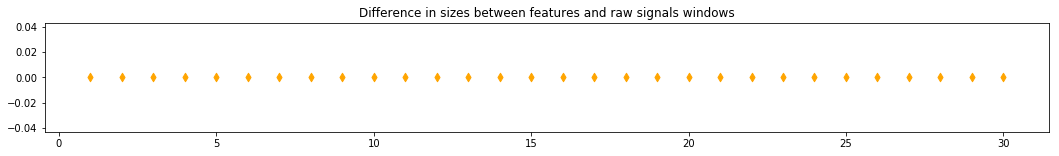

In [4]:
dif = []
for ids in sorted(list(fea.usr_train) + list(fea.usr_valid)) :
    if ids in fea.usr_train : cnt, fts = 0, len(np.where(fea.train['Subjects'] == ids)[0])
    elif ids in fea.usr_valid : cnt, fts = 0, len(np.where(fea.valid['Subjects'] == ids)[0])
    for val in des.query('User == {}'.format(ids)).values :
        cnt += windows(val[-1] - val[-2] + 1, fea.time_window, fea.overlap_rto)
    dif.append(cnt - fts)

plt.figure(figsize=(18,2))
plt.scatter(range(1,31), dif, marker='d', c='orange')
plt.title('Difference in sizes between features and raw signals windows')
plt.show()

We will also notice that some of the features labels are redundant, and will provok disturbances into the models. Among them, there is :

In [5]:
with open('./Fea_Data/features.txt') as raw : lab = raw.readlines()
for ind in range(len(lab)) : lab[ind] = lab[ind].replace('\n','').replace(' ','')
ele = remove_doublon([lbl for lbl in lab if len(np.where(np.asarray(lab) == lbl)[0]) > 1])
print(', '.join(ele))

tBodyAcc-ropy-1, tGravityAcc-ropy-1, tBodyAccJerk-ropy-1, tBodyGyro-ropy-1, tBodyGyroJerk-ropy-1, fBodyAcc-ropy-1, fBodyAcc-Skewness-1, fBodyAcc-Kurtosis-1, fBodyAccJerk-ropy-1, fBodyAccJerk-Skewness-1, fBodyAccJerk-Kurtosis-1, fBodyGyro-ropy-1, fBodyGyro-Skewness-1, fBodyGyro-Kurtosis-1


Concerning the raw signal and their corresponding features, we may observe :

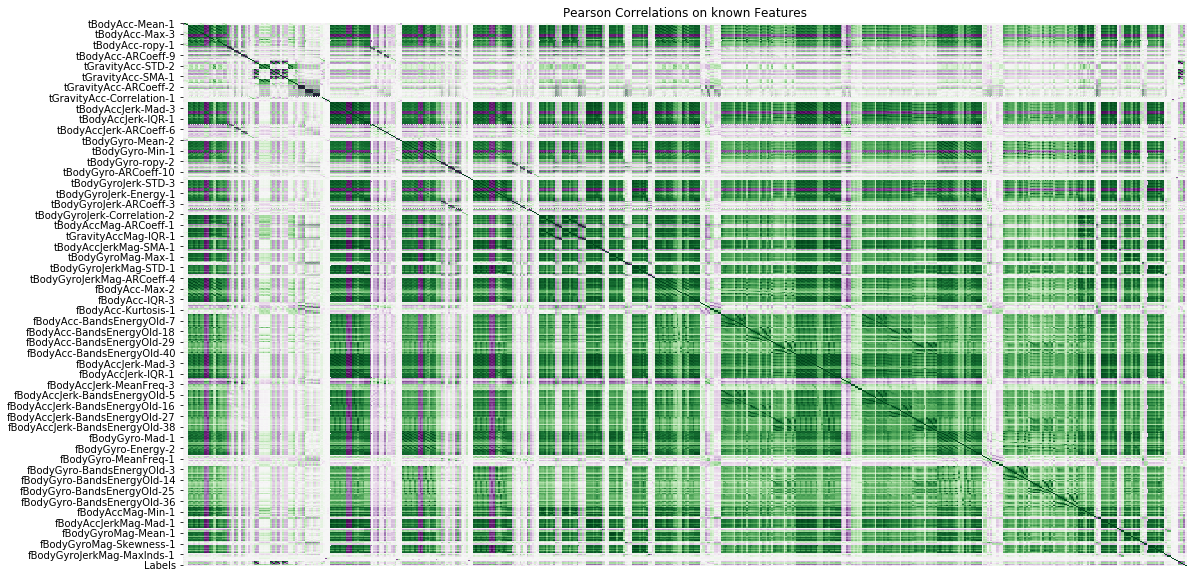

In [6]:
plt.figure(figsize=(18,10))
sb.heatmap(fea.train.corr(), cmap='PRGn', cbar=False, xticklabels=False)
_ = plt.title('Pearson Correlations on known Features')

As seen above, there are plenty of features strongly correlated together. The information brought thanks to those is clearly redundant, and selection has to be applied, as to enhance the rapidity of the training but also reduce a possible overfitting. Generalisation is still and ever the main aim of such exercice.

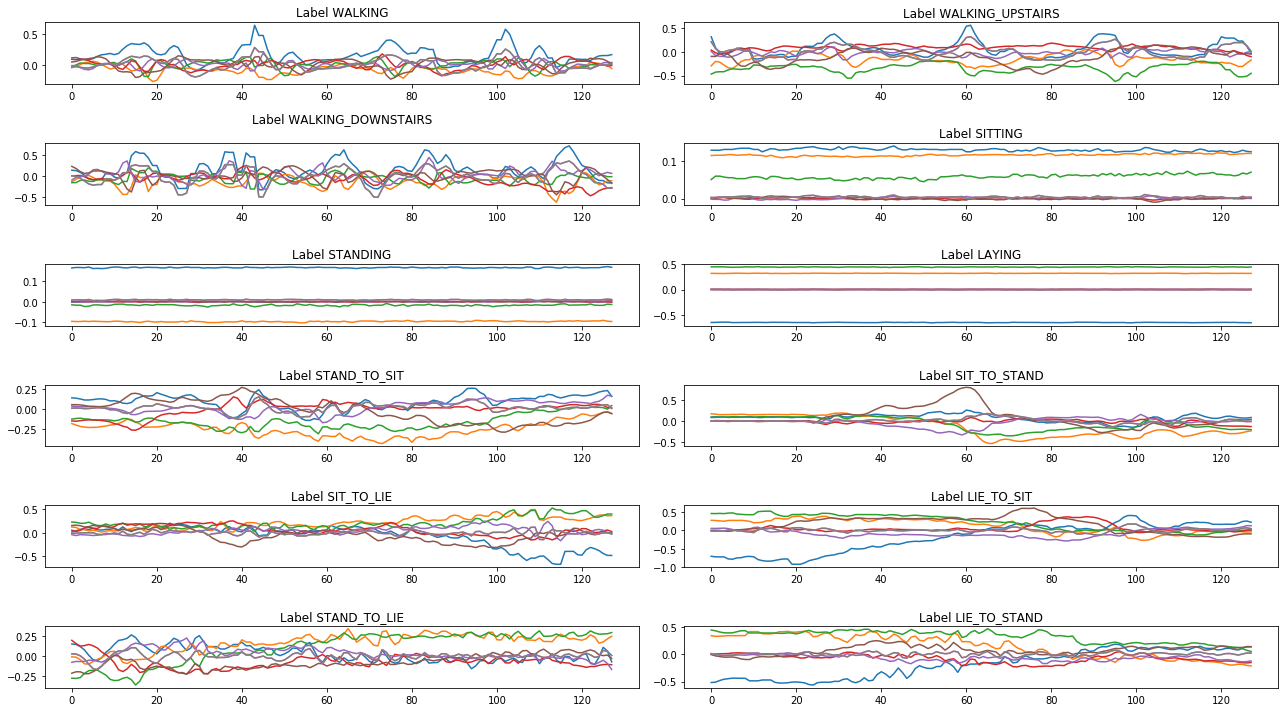

In [7]:
raw = Models('Conv1D', show_mean=False)
plt.figure(figsize=(18,10))
n_l = len(np.unique(raw.l_t))
for ind, lab in enumerate(np.unique(raw.l_t)) :
    plt.subplot((n_l + n_l%2)/2, 2, ind+1)
    plt.title('Label {}'.format(activities[lab]))
    plt.plot(raw.r_t[np.random.choice(np.where(raw.l_t == lab)[0])].transpose())
plt.tight_layout()
plt.show()

# Models Without Transitions

This first part consists in the development of my models, on the UCI dataset, which is smaller than the HAPT. The majority classes are the only one given in it, thus making the whole learning process easier. The scores are expected to be a lot higher than for the HAPT dataset.

### Features Only

In [8]:
Models('RandomForest', truncate=True, show_mean=False).load_model().performance()

,Main,Class_0,Class_1,Class_2,Class_3,Class_4,Class_5
Acc,0.962283,0.984703,0.983642,0.955810,0.959965,0.976231,0.999083
Rec,0.962283,0.975806,0.978769,0.916667,0.927165,0.967626,0.998165
Pre,0.962636,0.993484,0.988402,0.994525,0.992257,0.984571,1.000000
F1S,0.962194,0.984566,0.983562,0.954010,0.958608,0.976025,0.999082


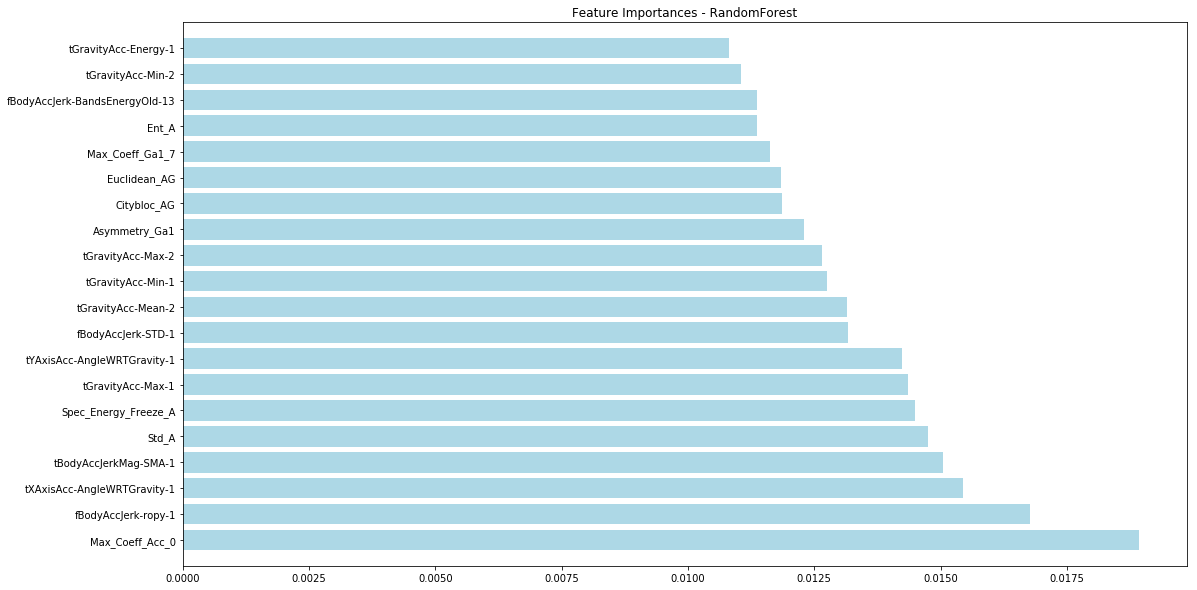

In [9]:
Models('RandomForest', truncate=True, show_mean=False).load_model().plot_importances()

In [10]:
Models('XGBoost', truncate=True, show_mean=False).load_model().performance()

,Main,Class_0,Class_1,Class_2,Class_3,Class_4,Class_5
Acc,0.955941,0.986544,0.968494,0.983967,0.945320,0.957505,1.0
Rec,0.955941,0.985887,0.940552,0.971429,0.905512,0.933453,1.0
Pre,0.956246,0.987183,0.996225,0.996416,0.983842,0.980625,1.0
F1S,0.955904,0.986535,0.967588,0.983764,0.943053,0.956458,1.0


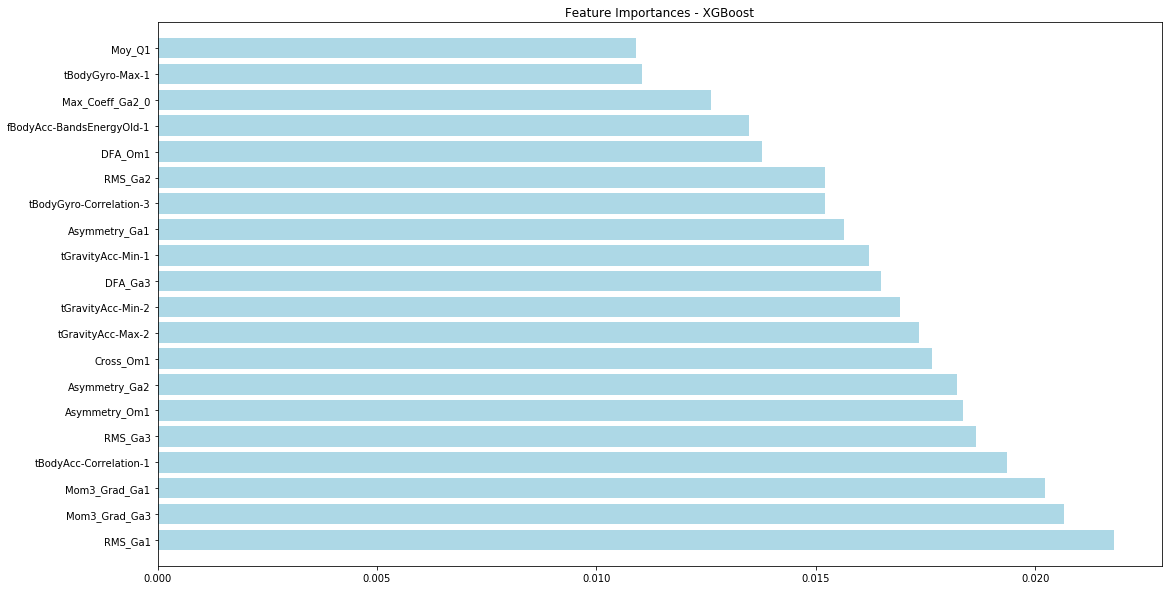

In [11]:
Models('XGBoost', truncate=True, show_mean=False).load_model().plot_importances()

### Raw Signals Only

In [12]:
Models('Conv1D', truncate=True, show_mean=False).load_model().performance()

,Main,Class_0,Class_1,Class_2,Class_3,Class_4,Class_5
Acc,0.955941,0.997184,0.997750,0.988898,0.929670,0.933054,1.0
Rec,0.955941,0.995968,0.997877,0.978571,0.883858,0.890288,1.0
Pre,0.955965,0.998396,0.997624,0.999207,0.973009,0.973558,1.0
F1S,0.955937,0.997180,0.997751,0.988782,0.926294,0.930063,1.0


In [13]:
Models('Conv2D', truncate=True, show_mean=False).load_model().performance()

,Main,Class_0,Class_1,Class_2,Class_3,Class_4,Class_5
Acc,0.857143,0.966734,0.970815,0.989493,0.850046,0.872631,0.860446
Rec,0.857143,0.933468,0.944798,0.997619,0.811024,0.775180,0.730275
Pre,0.877976,1.000000,0.996658,0.981664,0.879677,0.962839,0.987313
F1S,0.861357,0.965589,0.970035,0.989577,0.843956,0.858878,0.839561


In [14]:
Models('LSTM', truncate=True, show_mean=False).load_model().performance()

,Main,Class_0,Class_1,Class_2,Class_3,Class_4,Class_5
Acc,0.912884,0.956461,0.991144,0.983993,0.878706,0.885573,1.0
Rec,0.912884,0.915323,0.995754,0.973810,0.799213,0.812950,1.0
Pre,0.913510,0.997385,0.986658,0.994056,0.950297,0.951093,1.0
F1S,0.912806,0.954593,0.991185,0.983829,0.868231,0.876612,1.0


### Raw Signals and Features

In [15]:
Models('DeepConv1D', truncate=True, show_mean=False).load_model().performance()

,Main,Class_0,Class_1,Class_2,Class_3,Class_4,Class_5
Acc,0.969960,0.997984,0.993900,0.997645,0.938291,0.966737,1.0
Rec,0.969960,0.995968,0.989384,0.997619,0.885827,0.956835,1.0
Pre,0.970479,1.000000,0.998401,0.997671,0.989672,0.976167,1.0
F1S,0.969872,0.997980,0.993872,0.997645,0.934874,0.966404,1.0


In [16]:
Models('DeepConv2D', truncate=True, show_mean=False).load_model().performance()

,Main,Class_0,Class_1,Class_2,Class_3,Class_4,Class_5
Acc,0.962617,0.974598,0.994780,0.997645,0.930438,0.970288,1.0
Rec,0.962617,0.949597,0.997877,0.997619,0.868110,0.967626,1.0
Pre,0.964018,0.999579,0.991734,0.997671,0.991735,0.972806,1.0
F1S,0.962454,0.973947,0.994796,0.997645,0.925814,0.970209,1.0


In [ ]:
Models('DeepLSTM', truncate=True, show_mean=False).load_model().performance()

# Models With Transitions

Full development thoughout the HAPT dataset.

### Features Only

In [17]:
Models('RandomForest', show_mean=False).load_model().performance()

,Main,Class_0,Class_1,Class_2,Class_3,Class_4,Class_5,Class_6,Class_7,Class_8,Class_9,Class_10,Class_11
Acc,0.949715,0.984270,0.987499,0.952391,0.963563,0.977865,0.999083,0.934145,1.0,0.919958,0.758566,0.834968,0.738986
Rec,0.949715,0.973790,0.987261,0.909524,0.935039,0.967626,0.998165,0.869565,1.0,0.843750,0.520000,0.673469,0.481481
Pre,0.949609,0.994636,0.987731,0.994814,0.991609,0.987856,1.000000,0.998537,1.0,0.995477,0.994513,0.994781,0.992765
F1S,0.949246,0.984103,0.987496,0.950259,0.962494,0.977636,0.999082,0.929599,1.0,0.913355,0.682922,0.803182,0.648464


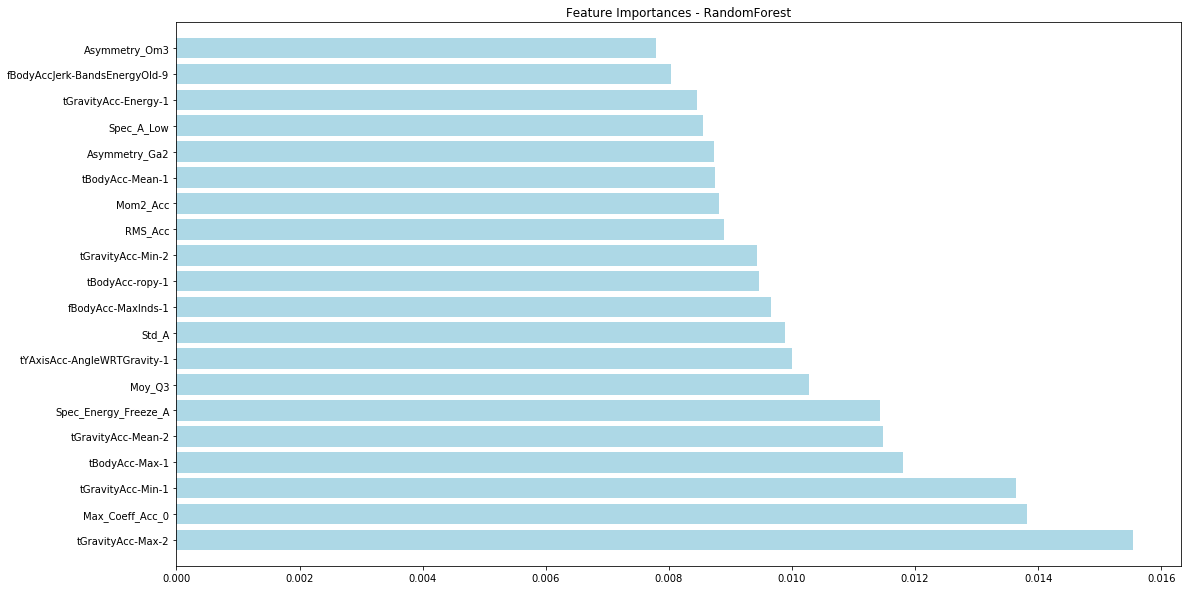

In [18]:
Models('RandomForest', show_mean=False).load_model().plot_importances()

In [19]:
Models('XGBoost', show_mean=False).load_model().performance()

,Main,Class_0,Class_1,Class_2,Class_3,Class_4,Class_5,Class_6,Class_7,Class_8,Class_9,Class_10,Class_11
Acc,0.947185,0.983777,0.969877,0.967224,0.961826,0.969064,0.999083,0.954132,0.999048,0.936062,0.798725,0.835610,0.813220
Rec,0.947185,0.975806,0.949045,0.938095,0.933071,0.949640,0.998165,0.913043,1.000000,0.875000,0.600000,0.673469,0.629630
Pre,0.949197,0.991614,0.990306,0.996127,0.990005,0.988023,1.000000,0.994794,0.998100,0.996725,0.995768,0.996672,0.994959
F1S,0.947543,0.983647,0.969236,0.966241,0.960695,0.968451,0.999082,0.952167,0.999049,0.931904,0.748806,0.803798,0.771218


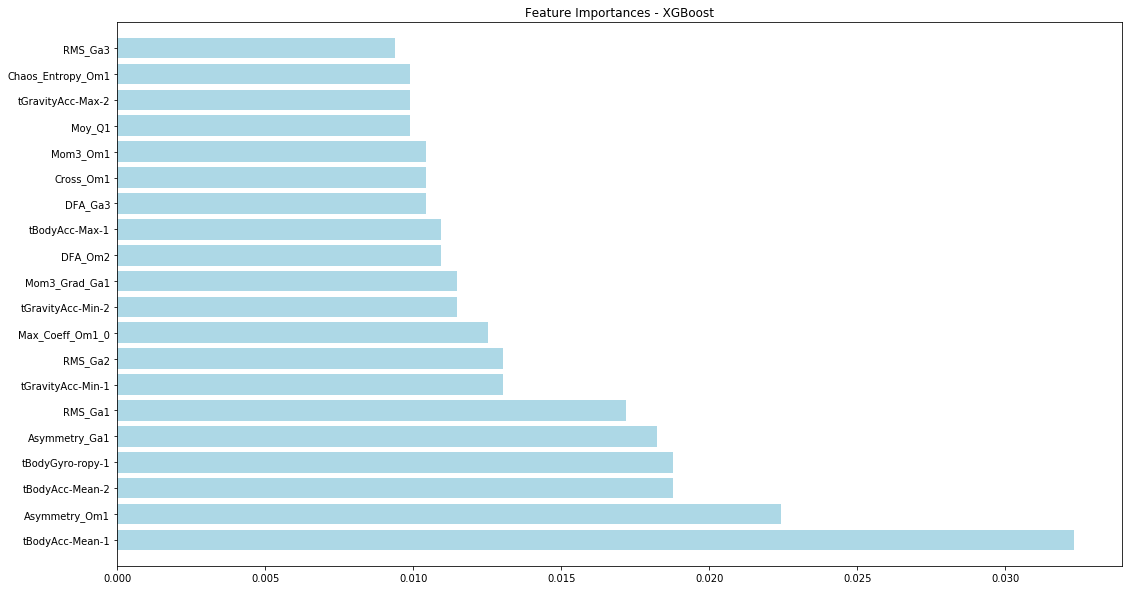

In [20]:
Models('XGBoost', show_mean=False).load_model().plot_importances()

### Raw Signals Only

In [21]:
Models('Conv1D', show_mean=False).load_model().performance()

,Main,Class_0,Class_1,Class_2,Class_3,Class_4,Class_5,Class_6,Class_7,Class_8,Class_9,Class_10,Class_11
Acc,0.936433,0.995686,0.997319,0.978389,0.931779,0.921486,1.0,0.869565,1.0,0.935104,0.858406,0.794473,0.739624
Rec,0.936433,1.000000,0.995754,0.957143,0.893701,0.863309,1.0,0.739130,1.0,0.875000,0.720000,0.591837,0.481481
Pre,0.937206,0.991447,0.998882,0.999619,0.967372,0.976984,1.0,1.000000,1.0,0.994553,0.995592,0.995139,0.995384
F1S,0.935928,0.995705,0.997315,0.977920,0.929078,0.916636,1.0,0.850000,1.0,0.930954,0.835661,0.742242,0.649022


In [22]:
Models('Conv2D', show_mean=False).load_model().performance()

,Main,Class_0,Class_1,Class_2,Class_3,Class_4,Class_5,Class_6,Class_7,Class_8,Class_9,Class_10,Class_11
Acc,0.867805,0.976510,0.972532,0.996257,0.871555,0.869867,0.924542,0.908106,1.0,0.871006,0.814103,0.742167,0.804448
Rec,0.867805,0.955645,0.946921,0.997619,0.791339,0.771583,0.851376,0.826087,1.0,0.750000,0.640000,0.489796,0.629630
Pre,0.893879,0.997260,0.998042,0.994908,0.942555,0.960358,0.997314,0.988186,1.0,0.989463,0.981904,0.988973,0.968120
F1S,0.877215,0.976009,0.971810,0.996262,0.860353,0.855682,0.918585,0.899895,1.0,0.853249,0.774915,0.655133,0.763019


In [ ]:
Models('LSTM', show_mean=False).load_model().performance()

### Raw Signals and Features

In [24]:
Models('DeepConv1D', show_mean=False).load_model().performance()

,Main,Class_0,Class_1,Class_2,Class_3,Class_4,Class_5,Class_6,Class_7,Class_8,Class_9,Class_10,Class_11
Acc,0.951613,0.994772,0.994825,0.995978,0.965766,0.936810,0.999809,0.933827,1.0,0.872764,0.877928,0.774547,0.702747
Rec,0.951613,0.989919,0.991507,0.995238,0.958661,0.881295,1.000000,0.869565,1.0,0.750000,0.760000,0.551020,0.407407
Pre,0.952949,0.999621,0.998130,0.996713,0.972480,0.991367,0.999618,0.997807,1.0,0.994072,0.994577,0.996514,0.995324
F1S,0.950841,0.994747,0.994807,0.995975,0.965521,0.933096,0.999809,0.929282,1.0,0.854958,0.861608,0.709644,0.578161


In [25]:
Models('DeepConv2D', show_mean=False).load_model().performance()

,Main,Class_0,Class_1,Class_2,Class_3,Class_4,Class_5,Class_6,Class_7,Class_8,Class_9,Class_10,Class_11
Acc,0.953827,0.984691,0.997638,0.996986,0.930852,0.976737,1.0,0.955725,0.999841,0.811382,0.818087,0.875624,0.720787
Rec,0.953827,0.969758,0.997877,0.997619,0.868110,0.978417,1.0,0.913043,1.000000,0.625000,0.640000,0.755102,0.444444
Pre,0.954508,0.999613,0.997400,0.996358,0.992675,0.975141,1.0,0.998258,0.999683,0.996434,0.994058,0.994921,0.993582
F1S,0.953218,0.984459,0.997638,0.996988,0.926224,0.976776,1.0,0.953751,0.999841,0.768174,0.778672,0.858579,0.614164


In [ ]:
Models('DeepLSTM', show_mean=False).load_model().performance()